In [1]:
import ee
import numpy as np
from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import predefined_cloud_algorithms

ee.Initialize()

region_of_interest = ee.Geometry.Polygon([[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]])
 
image_predict_clouds = ee.Image('LANDSAT/LC8_L1T_TOA_FMASK/LC81990332015174LGN00')
 
bands_model = ["B2","B3","B4"]
 
max_lags = 3
image_with_lags = multitemporal_cloud_masking.SelectImagesTraining(image_predict_clouds,region_of_interest,
                                                                   num_images=max_lags)
                                                                   

clouds_original = predefined_cloud_algorithms.QACloudMask(image_predict_clouds,strict=False)

# Add growing to the mask
clouds = clouds_original.reduceNeighborhood(ee.Reducer.max(),
                                            ee.Kernel.circle(radius=3))

modelo = multitemporal_cloud_masking.ModelCloudMasking(image_with_lags,bands_model,
                                                       clouds,max_lags,
                                                       region_of_interest,
                                                       seed=33)


### Test `_BuildDataSet`

In [2]:
from ee_ipl_uv import converters
modelo._BuildDataSet(sampling_factor=.001, normalize=False)
bme = list(modelo.bands_modeling_estimation)
bme.append("weight")
ds_download_pd = converters.eeFeatureCollectionToPandas(modelo.datos, bme,
                                                        with_task=False)



In [3]:
import pandas as pd
input_pd = ds_download_pd[modelo.bands_modeling_estimation_input]
output_pd = ds_download_pd[modelo.bands_modeling_estimation_output]

weights = ds_download_pd.weight

input_pd_norm = input_pd.apply(lambda x: (x -np.average(x,weights=weights))/np.std(x))
output_pd_norm = output_pd.apply(lambda x: (x -np.average(x,weights=weights)))

datos_norm = pd.concat([output_pd_norm,input_pd_norm],axis=1)
datos_norm.head()

,B2,B3,B4,B2_lag_1,B3_lag_1,B4_lag_1,B2_lag_2,B3_lag_2,B4_lag_2
0,-0.029462,-0.027399,-0.059526,-0.365184,0.072119,0.192025,0.020009,0.165043,0.203053
1,-0.032189,-0.043525,-0.051387,-0.733629,-0.182904,0.342277,-0.264303,0.020363,0.343647
2,0.004340,-0.018823,-0.046717,-0.558809,-1.129718,-1.191307,-1.009244,-1.474495,-1.525621
3,-0.034721,-0.042565,-0.083661,-0.882679,-0.330422,-0.627387,-0.718320,-0.510301,-0.644832
4,0.004798,-0.019172,-0.050056,-1.325649,-1.560220,-1.565352,-0.890964,-1.407523,-1.526951


In [4]:
modelo._BuildDataSet(sampling_factor=.001, normalize=True)
bme = list(modelo.bands_modeling_estimation)
bme.append("weight")
ds_download_pd_normalized = converters.eeFeatureCollectionToPandas(modelo.datos, bme,
                                                                   with_task=False)
ds_download_pd_normalized = ds_download_pd_normalized[modelo.bands_modeling_estimation]
# ds_download_pd_normalized.head()
np.testing.assert_allclose(ds_download_pd_normalized,datos_norm,rtol=1e-4)

## Check regressions
### Omega Local vs Truth Omega

In [5]:
input_pd_centrados = input_pd.apply(lambda x: (x -np.average(x,weights=weights)))

inputs_weight = input_pd_centrados.T.dot(np.diag(weights))
lmba_sin_norm = .1
tikhonov = np.identity(len(modelo.bands_modeling_estimation_input))*lmba_sin_norm

matriz_invertir = inputs_weight.dot(input_pd_centrados) + tikhonov
omega_a_mano = np.linalg.solve(matriz_invertir,inputs_weight.dot(output_pd_norm))
print(omega_a_mano)


[[ 0.00604115  0.00877676  0.01300708]
 [ 0.00756019  0.01322384  0.02060893]
 [ 0.01028457  0.01942354  0.03287572]
 [ 0.00586487  0.00812375  0.01161907]
 [ 0.00714205  0.01233809  0.01899531]
 [ 0.00981811  0.01847871  0.03109233]]


Notice `normalize=False`:

In [6]:
modelo.TrainLinearLocal(sampling_factor=.001,normalize=False,lmbda=lmba_sin_norm)
omega_local = np.asanyarray(modelo.omega.getInfo())
print(omega_local)
np.testing.assert_allclose(omega_local,omega_a_mano)

('Size of downloaded ds: ', (632, 10))
[[ 0.00604115  0.00877676  0.01300708]
 [ 0.00756019  0.01322384  0.02060893]
 [ 0.01028457  0.01942354  0.03287572]
 [ 0.00586487  0.00812375  0.01161907]
 [ 0.00714205  0.01233809  0.01899531]
 [ 0.00981811  0.01847871  0.03109233]]


In [7]:
lmbda=.1/ds_download_pd.shape[0]
modelo.TrainLinearLocal(sampling_factor=.001,normalize=True,lmbda=lmbda)
omega_local_norm = np.asanyarray(modelo.omega.getInfo())
intercept_local_norm = np.asanyarray(modelo.intercept.getInfo())
print(omega_local_norm)
print(intercept_local_norm)

('Size of downloaded ds: ', (632, 10))
[[ 0.35371881  0.23499053  0.24559219]
 [ 0.04279276  0.18636496  0.14233279]
 [ 0.00314291  0.08967802  0.31248084]
 [ 0.48929611  0.20023088 -0.0093181 ]
 [-0.05404176  0.09555694  0.02452757]
 [-0.05153731  0.04990469  0.28279391]]
[[ 0.02960845  0.0140411   0.00207146]]


### Omega server vs Omega local

In [8]:
# No son iguales porque la normalizacion es respecto a la media ponderada en el caso local y respecto a la media en 
# el caso no local
modelo.TrainLinearServer(sampling_factor=.001,lmbda=lmbda)
omega_server = np.asanyarray(modelo.omega.getInfo())
intercept_server = np.asanyarray(modelo.intercept.getInfo())
print(omega_server)
print(intercept_server)

[[ 0.35383764  0.23507232  0.24569062]
 [ 0.04273752  0.18633417  0.14229594]
 [ 0.00313712  0.08967046  0.31247115]
 [ 0.48933213  0.20023126 -0.00935549]
 [-0.05407735  0.09554392  0.02452712]
 [-0.05153321  0.04990877  0.28280412]]
[[ 0.02959873  0.01403574  0.0020677 ]]


In [9]:
assert np.sum((omega_local_norm-omega_server)**2) < 1e-4, "omega server different than omega"
assert np.sum((intercept_server-intercept_local_norm)**2) < 1e-4, "intercept server different than intercept local"

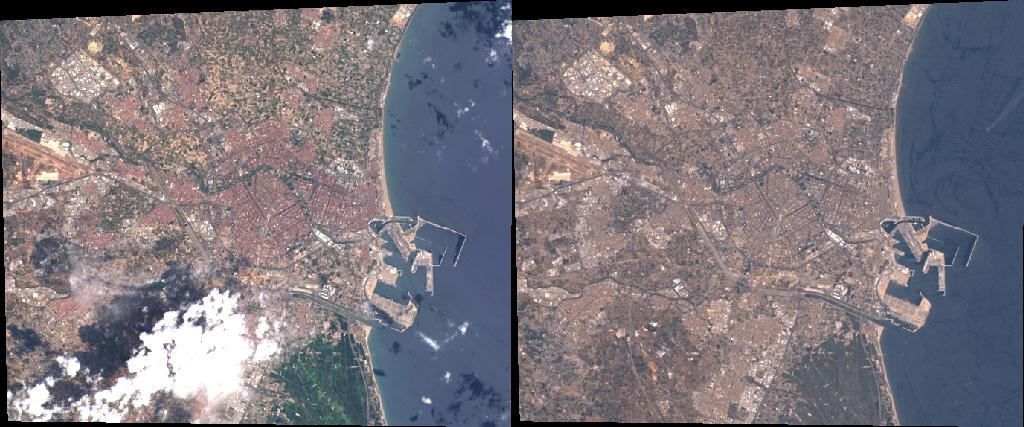

In [10]:
from ee_ipl_uv import download
from IPython.display import Image
img_predicha = modelo.PredictLinear()

image_file_forecast = download.MaybeDownloadThumb(img_predicha.clip(region_of_interest),
                                                  params={"max":.3,"bands":"B4_forecast,B3_forecast,B2_forecast"})
image_file_original = download.MaybeDownloadThumb(image_predict_clouds.clip(region_of_interest),
                                                   params={"max":.3,"bands":"B4,B3,B2"})

mosaico = download.MosaicImageList([image_file_original,image_file_forecast],[1,2])
Image(mosaico)